<a href="https://colab.research.google.com/github/Shahi77/Severity-classification-of-software-code-smells/blob/main/data_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lime
import seaborn as sns
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier as GBC
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier

import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
from __future__ import print_function

# from xgboost import XGBClassifier
import lime
import lime.lime_tabular

%matplotlib inline

train_df = pd.read_csv('dataset-data-class.csv')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=850c80afba2b08b3e57378d55d4416785d757de26c44d932537a399a250b83b3
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
train_df = pd.read_csv('dataset-data-class.csv', header=0)
test_df = pd.read_csv('dataset-data-class.csv', header=0)
cols=train_df.columns

In [4]:
train_df['source']='train'
test_df['source']='test'
data = pd.concat([train_df, test_df],ignore_index=True)
print (train_df.shape, test_df.shape, data.shape)

(420, 69) (420, 69) (840, 69)


In [5]:
#Divide into test and train:
train_df = data.loc[data['source']=="train"]
test_df = data.loc[data['source']=="test"]
train_df.head()

dataset      project package           complextype  severity  \
0  data-class  fitjava-1.1     fat  DocumentParseFixture       1.0   
1  data-class  fitjava-1.1     fat            Frameworks       1.0   
2  data-class  fitjava-1.1     fat     TableParseFixture       1.0   
3  data-class  fitjava-1.1     fat                Divide       1.0   
4  data-class  fitjava-1.1     fat    FixtureNameFixture       1.0   

   AMWNAMM_type  AMW_type  ATFD_type  CBO_type  CFNAMM_type  ...  \
0           1.5       1.5        3.0       5.0          2.0  ...   
1           2.0       2.0        0.0       5.0          0.0  ...   
2           1.0       1.0        2.0       5.0          2.0  ...   
3           1.0       1.0        0.0       5.0          0.0  ...   
4           2.0       2.0        0.0       5.0          3.0  ...   

   number_package_visibility_methods  number_private_visibility_attributes  \
0                                0.0                                   0.0   
1                                0.0                                   0.0   
2                                0.0                                   0.0   
3                                0.0                                   0.0   
4                                0.0                                   0.0   

   number_private_visibility_methods  number_protected_visibility_attributes  \
0                                4.0                                     0.0   
1                                0.0                                     0.0   
2                                3.0                                     0.0   
3                                0.0                                     0.0   
4                                3.0                                     0.0   

   number_protected_visibility_methods  number_public_visibility_methods  \
0                                  0.0                               2.0   
1                                  0.0                               2.0   
2                                  0.0                               4.0   
3                                  0.0                               1.0   
4                                  0.0                               1.0   

   number_standard_design_methods  number_static_methods  visibility_type  \
0                             6.0                    0.0           public   
1                             2.0                    0.0           public   
2                             7.0                    0.0           public   
3                             1.0                    0.0           public   
4                             4.0                    0.0           public   

   source  
0   train  
1   train  
2   train  
3   train  
4   train  

[5 rows x 69 columns]

In [6]:
# Drop unwanted columns
train_df = train_df.drop(['dataset','project','package',
                          'complextype','visibility_type','source',],axis=1)

In [7]:
#### Extract the label column
train_target = np.ravel(np.array(train_df['severity'].values))


In [8]:
# Extract features
float_columns=[]
cat_columns=[]
int_columns=[]

for i in train_df.columns:
    if train_df[i].dtype == 'float' :
        float_columns.append(i)
    elif train_df[i].dtype == 'int64':
        int_columns.append(i)
    elif train_df[i].dtype == 'object':
        cat_columns.append(i)

train_cat_features = train_df[cat_columns]
train_float_features = train_df[float_columns]
train_int_features = train_df[int_columns]
train_df.head()

severity  AMWNAMM_type  AMW_type  ATFD_type  CBO_type  CFNAMM_type  \
0       1.0           1.5       1.5        3.0       5.0          2.0   
1       1.0           2.0       2.0        0.0       5.0          0.0   
2       1.0           1.0       1.0        2.0       5.0          2.0   
3       1.0           1.0       1.0        0.0       5.0          0.0   
4       1.0           2.0       2.0        0.0       5.0          3.0   

   DIT_type  FANOUT_type  LCOM5_type  LOCNAMM_type  ...  \
0       3.0          1.0         1.0          54.0  ...   
1       3.0          0.0         0.5          18.0  ...   
2       3.0          1.0         1.0          34.0  ...   
3       3.0          0.0         0.0           4.0  ...   
4       3.0          2.0         1.0          35.0  ...   

   number_not_final_static_methods  number_package_visibility_attributes  \
0                              0.0                                   0.0   
1                              0.0                                   0.0   
2                              0.0                                   0.0   
3                              0.0                                   0.0   
4                              0.0                                   0.0   

   number_package_visibility_methods  number_private_visibility_attributes  \
0                                0.0                                   0.0   
1                                0.0                                   0.0   
2                                0.0                                   0.0   
3                                0.0                                   0.0   
4                                0.0                                   0.0   

   number_private_visibility_methods  number_protected_visibility_attributes  \
0                                4.0                                     0.0   
1                                0.0                                     0.0   
2                                3.0                                     0.0   
3                                0.0                                     0.0   
4                                3.0                                     0.0   

   number_protected_visibility_methods  number_public_visibility_methods  \
0                                  0.0                               2.0   
1                                  0.0                               2.0   
2                                  0.0                               4.0   
3                                  0.0                               1.0   
4                                  0.0                               1.0   

   number_standard_design_methods  number_static_methods  
0                             6.0                    0.0  
1                             2.0                    0.0  
2                             7.0                    0.0  
3                             1.0                    0.0  
4                             4.0                    0.0  

[5 rows x 63 columns]

In [9]:
## Transformation of categorical columns&  Label Encoding:
train_cat_features_ver2 = train_cat_features.apply(LabelEncoder().fit_transform)
train_df.head()

severity  AMWNAMM_type  AMW_type  ATFD_type  CBO_type  CFNAMM_type  \
0       1.0           1.5       1.5        3.0       5.0          2.0   
1       1.0           2.0       2.0        0.0       5.0          0.0   
2       1.0           1.0       1.0        2.0       5.0          2.0   
3       1.0           1.0       1.0        0.0       5.0          0.0   
4       1.0           2.0       2.0        0.0       5.0          3.0   

   DIT_type  FANOUT_type  LCOM5_type  LOCNAMM_type  ...  \
0       3.0          1.0         1.0          54.0  ...   
1       3.0          0.0         0.5          18.0  ...   
2       3.0          1.0         1.0          34.0  ...   
3       3.0          0.0         0.0           4.0  ...   
4       3.0          2.0         1.0          35.0  ...   

   number_not_final_static_methods  number_package_visibility_attributes  \
0                              0.0                                   0.0   
1                              0.0                                   0.0   
2                              0.0                                   0.0   
3                              0.0                                   0.0   
4                              0.0                                   0.0   

   number_package_visibility_methods  number_private_visibility_attributes  \
0                                0.0                                   0.0   
1                                0.0                                   0.0   
2                                0.0                                   0.0   
3                                0.0                                   0.0   
4                                0.0                                   0.0   

   number_private_visibility_methods  number_protected_visibility_attributes  \
0                                4.0                                     0.0   
1                                0.0                                     0.0   
2                                3.0                                     0.0   
3                                0.0                                     0.0   
4                                3.0                                     0.0   

   number_protected_visibility_methods  number_public_visibility_methods  \
0                                  0.0                               2.0   
1                                  0.0                               2.0   
2                                  0.0                               4.0   
3                                  0.0                               1.0   
4                                  0.0                               1.0   

   number_standard_design_methods  number_static_methods  
0                             6.0                    0.0  
1                             2.0                    0.0  
2                             7.0                    0.0  
3                             1.0                    0.0  
4                             4.0                    0.0  

[5 rows x 63 columns]

In [10]:
## Transformation of float columns
scaler = MinMaxScaler(feature_range=(0, 1))
for i in train_float_features.columns:
    X_temp = train_float_features.loc[:,i].values.reshape(-1,1)
    train_float_features.loc[:,i] = scaler.fit_transform(X_temp)

In [11]:
#### Finalize X & Y
temp_1 = np.concatenate((train_cat_features_ver2,train_float_features),axis=1)
train_transformed_features = np.concatenate((temp_1,train_int_features),axis=1)
train_transformed_features = pd.DataFrame(data=train_transformed_features)
train_target = np.ravel(np.array(train_df['severity'].values))

array = train_transformed_features.values
number_of_features = len(array[0])
X = array[:,0:number_of_features]
Y = train_target

In [12]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, mean_squared_error, r2_score, f1_score,
    confusion_matrix, roc_auc_score, precision_score, recall_score, log_loss
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Configuration
seed = 7
splits = {
    "50-50": 0.5,
    "60-40": 0.4,
    "70-30": 0.3,
    "80-20": 0.2,
    "90-10": 0.1,
}
learning_rates = [0.01, 0.1, 0.2, 0.5]  # Example learning rates

# Classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True),
    "RBF": SVC(probability=True, kernel='rbf'),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naïve Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
    # Uncomment if XGBoost is available
    # "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss'),
}

# Dictionary to store results
data_splits = {}
results = {}

# Split the dataset
for split_name, test_size in splits.items():
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=test_size, random_state=seed)
    data_splits[split_name] = {
        "X_train": X_train,
        "X_validation": X_validation,
        "Y_train": Y_train,
        "Y_validation": Y_validation,
    }

# Evaluation
for split_name, split_data in data_splits.items():
    X_train = split_data["X_train"]
    X_validation = split_data["X_validation"]
    Y_train = split_data["Y_train"]
    Y_validation = split_data["Y_validation"]

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_validation = imputer.transform(X_validation)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train, Y_train = smote.fit_resample(X_train, Y_train)

    # Store results for each classifier
    results[split_name] = {}

    for clf_name, model in classifiers.items():
        for lr in learning_rates:
            if hasattr(model, "learning_rate"):
                model.set_params(learning_rate=lr)

            start_time = time.time()
            model.fit(X_train, Y_train)

            # Predictions
            predictions = model.predict(X_validation)
            prob_predictions = model.predict_proba(X_validation) if hasattr(model, "predict_proba") else None

            end_time = time.time()
            computation_time = end_time - start_time

            # Metrics
            accuracy = accuracy_score(Y_validation, predictions)
            f1 = f1_score(Y_validation, predictions, average='weighted')
            precision = precision_score(Y_validation, predictions, average='weighted', zero_division=0)
            recall = recall_score(Y_validation, predictions, average='weighted', zero_division=0)
            log_loss_value = log_loss(Y_validation, prob_predictions) if prob_predictions is not None else np.nan
            roc_auc = roc_auc_score(Y_validation, prob_predictions[:, 1]) if prob_predictions is not None and len(np.unique(Y_validation)) == 2 else np.nan
            mae = mean_absolute_error(Y_validation, predictions)
            mse = mean_squared_error(Y_validation, predictions)
            rmse = np.sqrt(mse)
            r_squared = r2_score(Y_validation, predictions)

            # Save results
            results[split_name][f"{clf_name} (lr={lr})"] = {
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "Log Loss": log_loss_value,
                "ROC AUC": roc_auc,
                "MAE": mae,
                "MSE": mse,
                "RMSE": rmse,
                "R-Squared": r_squared,
                "Computation Time": computation_time,
            }

# Export to Excel
excel_data = []
for split_name, models in results.items():
    for clf_name, metrics in models.items():
        row = {"Split Name": split_name, "Model": clf_name}
        row.update(metrics)
        excel_data.append(row)

df = pd.DataFrame(excel_data)
output_file = 'results_with_learning_rates_DataClass.xlsx'
df.to_excel(output_file, index=False)

print(f"Results saved to {output_file}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: T

Results saved to results_with_learning_rates_DataClass.xlsx


In [ ]:
# Split into training and validation sets for multiple sizes
seed = 7
splits = {
    "50-50": 0.5,
    "60-40": 0.4,
    "70-30": 0.3,
    "80-20": 0.2,
    "90-10": 0.1,
}


# Dictionary to hold the results
data_splits = {}

for split_name, test_size in splits.items():
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=test_size, random_state=seed)
    data_splits[split_name] = {
        "X_train": X_train,
        "X_validation": X_validation,
        "Y_train": Y_train,
        "Y_validation": Y_validation,
    }

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC as SVC_RBF
import xgboost as xgb

# Assume data_splits is already created as shown before
results = {}

# Define the classifiers you want to evaluate, including AdaBoost
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True),
    "RBF": SVC_RBF(probability=True, kernel='rbf'),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naïve Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),  # Added AdaBoost Classifier
    # "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss'),
}

for split_name, split_data in data_splits.items():
    X_train = split_data["X_train"]
    X_validation = split_data["X_validation"]
    Y_train = split_data["Y_train"]
    Y_validation = split_data["Y_validation"]

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_validation = imputer.transform(X_validation)

    # Apply SMOTE for class balancing
    smote = SMOTE(random_state=42)
    X_train, Y_train = smote.fit_resample(X_train, Y_train)

    # Store results for each classifier
    results[split_name] = {}

    for clf_name, model in classifiers.items():
        start_time = time.time()

        model.fit(X_train, Y_train)

        # Predictions
        predictions = model.predict(X_validation)
        if hasattr(model, "predict_proba"):
            prob_predictions = model.predict_proba(X_validation)
        else:
            prob_predictions = None

        end_time = time.time()
        computation_time = end_time - start_time

        # Evaluation Metrics
        accuracy = accuracy_score(Y_validation, predictions)
        mae = mean_absolute_error(Y_validation, predictions)
        mse = mean_squared_error(Y_validation, predictions)
        rmse = np.sqrt(mse)
        r_squared = r2_score(Y_validation, predictions)
        mape = np.mean(np.abs((Y_validation - predictions) / Y_validation)) * 100 if np.all(Y_validation) else np.nan
        f1 = f1_score(Y_validation, predictions, average='weighted')
        cm = confusion_matrix(Y_validation, predictions)

        precision = precision_score(Y_validation, predictions, average='weighted', zero_division=0)
        recall = recall_score(Y_validation, predictions, average='weighted', zero_division=0)
        log_loss_value = log_loss(Y_validation, prob_predictions) if prob_predictions is not None else np.nan
        roc_auc = roc_auc_score(Y_validation, prob_predictions[:, 1]) if prob_predictions is not None and len(np.unique(Y_validation)) == 2 else np.nan

        pred_25 = np.mean(predictions >= 25) * 100
        n = len(Y_validation)
        p = X_validation.shape[1]
        adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
        mbd = np.mean(predictions - Y_validation)
        cv = np.std(predictions) / np.mean(predictions) if np.mean(predictions) != 0 else np.nan

        # Store results for this model
        results[split_name][clf_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Log Loss": log_loss_value,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R-Squared": r_squared,
            "Computation Time": computation_time,
            "MAPE": mape,
            "Adjusted R-Squared": adjusted_r_squared,
            "MBD": mbd,
            "CV": cv,
        }

# Prepare data for Excel export
excel_data = []
for split_name, models in results.items():
    for clf_name, metrics in models.items():
        row = {"Split Name": split_name, "Model": clf_name}
        row.update(metrics)
        excel_data.append(row)

# Create a DataFrame
df = pd.DataFrame(excel_data)

# Save the DataFrame to an Excel file
output_file = 'results_DataClass.xlsx'
df.to_excel(output_file, index=False)

print(f'Results saved to {output_file}')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and

Results saved to model_evaluation_results_with_smote_DC.xlsx


In [ ]:
# Model RandomForest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, Y_train)
accuracy_score(Y_validation, model_rf.predict(X_validation))

0.9047619047619048

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assume data_splits is already created as shown before
results = {}

for split_name, split_data in data_splits.items():
    X_train = split_data["X_train"]
    X_validation = split_data["X_validation"]
    Y_train = split_data["Y_train"]
    Y_validation = split_data["Y_validation"]

    # Model 1 - RandomForest Classifier
    model_rf = RandomForestClassifier()
    model_rf.fit(X_train, Y_train)

    # Evaluate the model
    accuracy = accuracy_score(Y_validation, model_rf.predict(X_validation))

    # Store the accuracy result for each split
    results[split_name] = accuracy

# Print the results for each split
for split_name, accuracy in results.items():
    print(f'Accuracy for {split_name}: {accuracy}')


Accuracy for 50-50: 0.7952380952380952
Accuracy for 60-40: 0.8511904761904762
Accuracy for 70-30: 0.8809523809523809
Accuracy for 80-20: 0.8809523809523809
Accuracy for 90-10: 0.9047619047619048


In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, mean_absolute_error, mean_squared_error, r2_score,
                             confusion_matrix, f1_score, roc_curve, roc_auc_score)
import time

# Assume data_splits is already created as shown before
results = {}

for split_name, split_data in data_splits.items():
    X_train = split_data["X_train"]
    X_validation = split_data["X_validation"]
    Y_train = split_data["Y_train"]
    Y_validation = split_data["Y_validation"]

    # Model 1 - RandomForest Classifier
    model_rf = RandomForestClassifier()

    # Start time measurement
    start_time = time.time()

    model_rf.fit(X_train, Y_train)

    # Predictions
    predictions = model_rf.predict(X_validation)

    # Stop time measurement
    end_time = time.time()
    computation_time = end_time - start_time

    # Evaluation Metrics
    accuracy = accuracy_score(Y_validation, predictions)
    mae = mean_absolute_error(Y_validation, predictions)
    mse = mean_squared_error(Y_validation, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(Y_validation, predictions)
    mape = np.mean(np.abs((Y_validation - predictions) / Y_validation)) * 100 if np.all(Y_validation) else np.nan
    f1 = f1_score(Y_validation, predictions, average='weighted')
    cm = confusion_matrix(Y_validation, predictions)

    # PRED (25): The percentage of predictions that are correct
    pred_25 = np.mean(predictions >= 25) * 100  # Assuming predictions are numerical

    # Adjusted R-Squared
    n = len(Y_validation)  # Number of observations
    p = X_validation.shape[1]  # Number of features
    adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    # Mean Bias Deviation (MBD)
    mbd = np.mean(predictions - Y_validation)

    # Coefficient of Variation (CV)
    cv = np.std(predictions) / np.mean(predictions) if np.mean(predictions) != 0 else np.nan

    # Store results for each split
    results[split_name] = {
        "Accuracy": accuracy,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R-Squared": r_squared,
        "Computation Time": computation_time,
        "MAPE": mape,
        "Adjusted R-Squared": adjusted_r_squared,
        "MBD": mbd,
        "CV": cv,
        "F1 Score": f1,
        "Confusion Matrix": cm,
        "ROC AUC": roc_auc_score(Y_validation, model_rf.predict_proba(X_validation)[:, 1]) if len(np.unique(Y_validation)) == 2 else np.nan,
    }

# Print the results for each split
for split_name, metrics in results.items():
    print(f'Results for {split_name}:')
    for metric_name, metric_value in metrics.items():
        print(f'{metric_name}: {metric_value}')
    print('\n')

NameError: name 'data_splits' is not defined

In [ ]:
pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Assume data_splits is already created as shown before
results = {}

# Define the classifiers you want to evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

for split_name, split_data in data_splits.items():
    X_train = split_data["X_train"]
    X_validation = split_data["X_validation"]
    Y_train = split_data["Y_train"]
    Y_validation = split_data["Y_validation"]

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')  # or another strategy
    X_train = imputer.fit_transform(X_train)
    X_validation = imputer.transform(X_validation)

    # Store results for each classifier
    results[split_name] = {}

    for clf_name, model in classifiers.items():
        # Start time measurement
        start_time = time.time()

        model.fit(X_train, Y_train)

        # Predictions
        predictions = model.predict(X_validation)

        # Stop time measurement
        end_time = time.time()
        computation_time = end_time - start_time

        # Evaluation Metrics
        accuracy = accuracy_score(Y_validation, predictions)
        mae = mean_absolute_error(Y_validation, predictions)
        mse = mean_squared_error(Y_validation, predictions)
        rmse = np.sqrt(mse)
        r_squared = r2_score(Y_validation, predictions)
        mape = np.mean(np.abs((Y_validation - predictions) / Y_validation)) * 100 if np.all(Y_validation) else np.nan
        f1 = f1_score(Y_validation, predictions, average='weighted')
        cm = confusion_matrix(Y_validation, predictions)

        # PRED (25): The percentage of predictions that are correct
        pred_25 = np.mean(predictions >= 25) * 100  # Assuming predictions are numerical

        # Adjusted R-Squared
        n = len(Y_validation)  # Number of observations
        p = X_validation.shape[1]  # Number of features
        adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

        # Mean Bias Deviation (MBD)
        mbd = np.mean(predictions - Y_validation)

        # Coefficient of Variation (CV)
        cv = np.std(predictions) / np.mean(predictions) if np.mean(predictions) != 0 else np.nan

        # Store results for this model
        results[split_name][clf_name] = {
            "Accuracy": accuracy,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R-Squared": r_squared,
            "Computation Time": computation_time,
            "MAPE": mape,
            "Adjusted R-Squared": adjusted_r_squared,
            "MBD": mbd,
            "CV": cv,
            "F1 Score": f1,
            "Confusion Matrix": cm,
            "ROC AUC": roc_auc_score(Y_validation, model.predict_proba(X_validation)[:, 1]) if len(np.unique(Y_validation)) == 2 else np.nan,
        }

# Print the results for each split
for split_name, models in results.items():
    print(f'Results for {split_name}:')
    for clf_name, metrics in models.items():
        print(f'\nModel: {clf_name}')
        for metric_name, metric_value in metrics.items():
            print(f'{metric_name}: {metric_value}')


Results for 50-50:

Model: Random Forest
Accuracy: 0.8333333333333334
MAE: 0.18095238095238095
MSE: 0.21904761904761905
RMSE: 0.4680252333449758
R-Squared: 0.8578910203601271
Computation Time: 0.4024202823638916
MAPE: 8.849206349206348
Adjusted R-Squared: 0.7965700222963463
MBD: 0.047619047619047616
CV: 0.4730326873248245
F1 Score: 0.8106528101856515
Confusion Matrix: [[66  0  1  1]
 [ 5  4 15  0]
 [ 0  0 46  4]
 [ 0  0  9 59]]
ROC AUC: nan

Model: Logistic Regression
Accuracy: 0.7952380952380952
MAE: 0.20952380952380953
MSE: 0.21904761904761905
RMSE: 0.4680252333449758
R-Squared: 0.8578910203601271
Computation Time: 0.059435129165649414
MAPE: 9.206349206349206
Adjusted R-Squared: 0.7965700222963463
MBD: 0.009523809523809525
CV: 0.5030769521187454
F1 Score: 0.7479125653038696
Confusion Matrix: [[67  0  1  0]
 [13  0 11  0]
 [ 0  0 40 10]
 [ 0  0  8 60]]
ROC AUC: nan

Model: Support Vector Machine
Accuracy: 0.8380952380952381
MAE: 0.1619047619047619
MSE: 0.1619047619047619
RMSE: 0.40237

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create and fit the Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, Y_train)

# Make predictions on the validation set
predictions = model_rf.predict(X_validation)

# Calculate accuracy
accuracy = accuracy_score(Y_validation, predictions)
print("Accuracy:", accuracy)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_validation, predictions))

# Print classification report
print("Classification Report:")
print(classification_report(Y_validation, predictions))

Accuracy: 0.9285714285714286
Confusion Matrix:
[[14  0  1  0]
 [ 0  3  0  0]
 [ 0  0  6  0]
 [ 0  0  2 16]]
Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      0.93      0.97        15
         2.0       1.00      1.00      1.00         3
         3.0       0.67      1.00      0.80         6
         4.0       1.00      0.89      0.94        18

    accuracy                           0.93        42
   macro avg       0.92      0.96      0.93        42
weighted avg       0.95      0.93      0.93        42



In [ ]:
model_rf = RandomForestClassifier()
model_rf.fit(X, Y)

RandomForestClassifier()

In [ ]:
feature_names_cat = list(train_cat_features_ver2)
feature_names_float = list(train_float_features)
feature_names_int = list(train_int_features)

feature_names = sum([feature_names_cat, feature_names_float, feature_names_int], [])
print(feature_names)

['modifier_type', 'severity', 'AMWNAMM_type', 'AMW_type', 'ATFD_type', 'CBO_type', 'CFNAMM_type', 'DIT_type', 'FANOUT_type', 'LCOM5_type', 'LOCNAMM_type', 'LOC_package', 'LOC_project', 'LOC_type', 'NIM_type', 'NMO_type', 'NOAM_type', 'NOA_type', 'NOCS_package', 'NOCS_project', 'NOCS_type', 'NOC_type', 'NOII_type', 'NOI_package', 'NOI_project', 'NOMNAMM_package', 'NOMNAMM_project', 'NOMNAMM_type', 'NOM_package', 'NOM_project', 'NOM_type', 'NOPA_type', 'NOPK_project', 'RFC_type', 'TCC_type', 'WMCNAMM_type', 'WMC_type', 'WOC_type', 'isStatic_type', 'num_final_attributes', 'num_final_not_static_attributes', 'num_final_static_attributes', 'num_not_final_not_static_attributes', 'num_static_attributes', 'num_static_not_final_attributes', 'number_abstract_methods', 'number_constructor_DefaultConstructor_methods', 'number_constructor_NotDefaultConstructor_methods', 'number_final_methods', 'number_final_not_static_methods', 'number_final_static_methods', 'number_not_abstract_not_final_methods', 

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train ,feature_names = feature_names,class_names=['1','2','3'],
                                                   categorical_features=cat_columns,
                                                   categorical_names=feature_names_cat, kernel_width=3)

In [ ]:
# Pick the observation in the validation set for which explanation is required
observation_1 = 2

In [ ]:
predict_fn_logreg = lambda x: model_logreg.predict_proba(x).astype(float)
predict_fn_rf = lambda x: model_rf.predict_proba(x).astype(float)
predict_fn_xgb = lambda x: model_xgb.predict_proba(x).astype(float)

In [ ]:
# Get the explanation for RandomForest
observation_1 = 4
exp = explainer.explain_instance(X_validation[observation_1], predict_fn_rf, num_features=6)
exp.show_in_notebook(show_all=False)

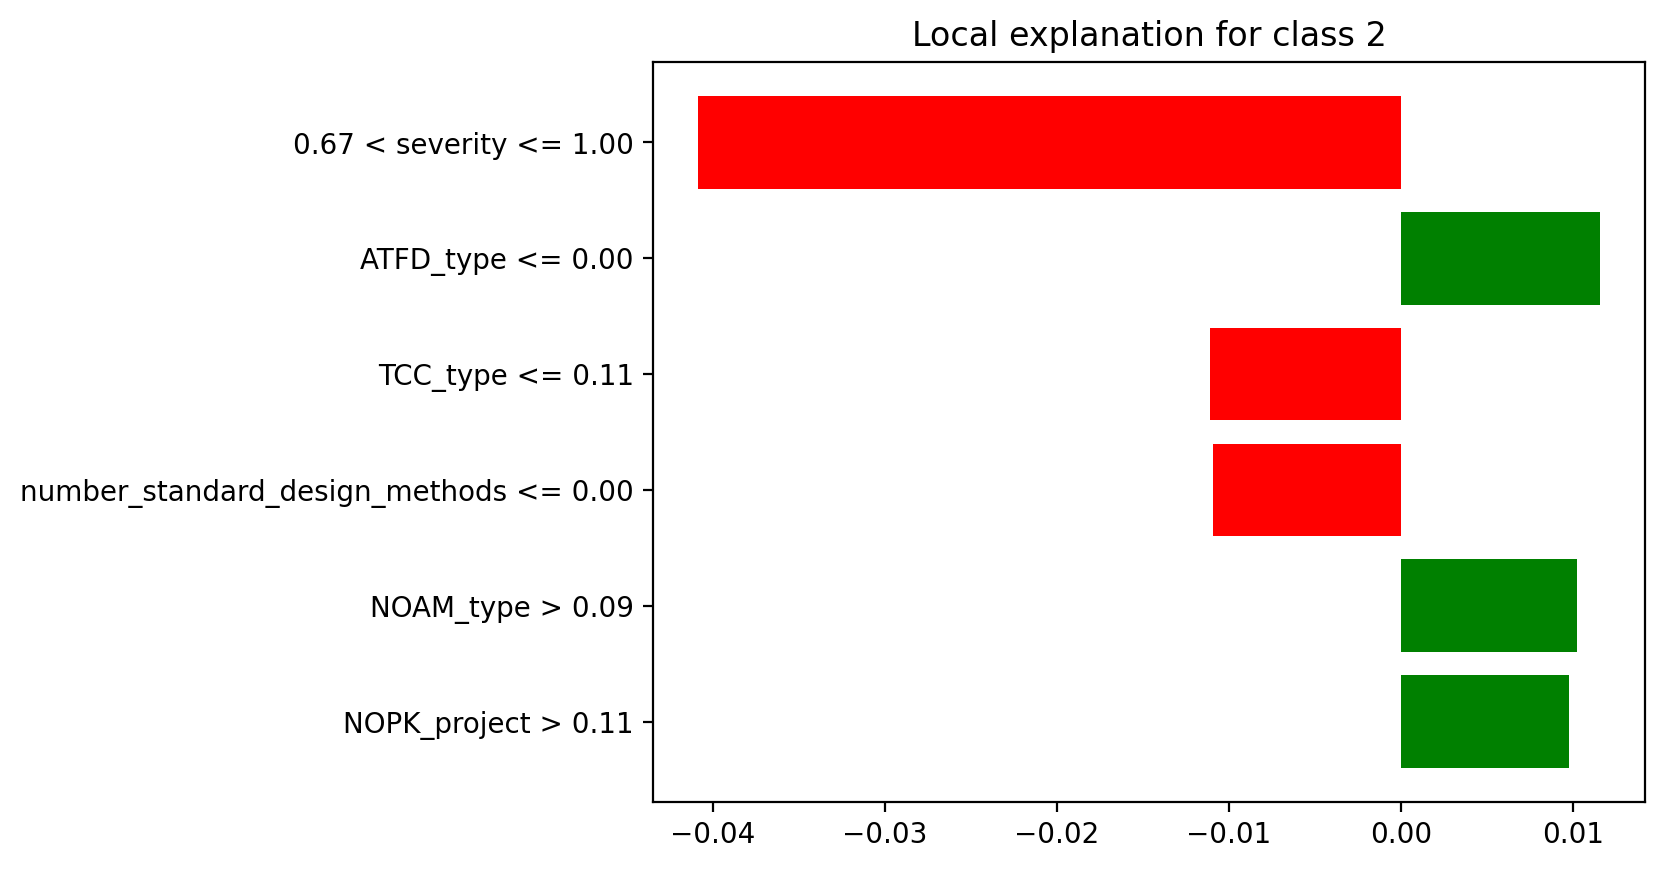

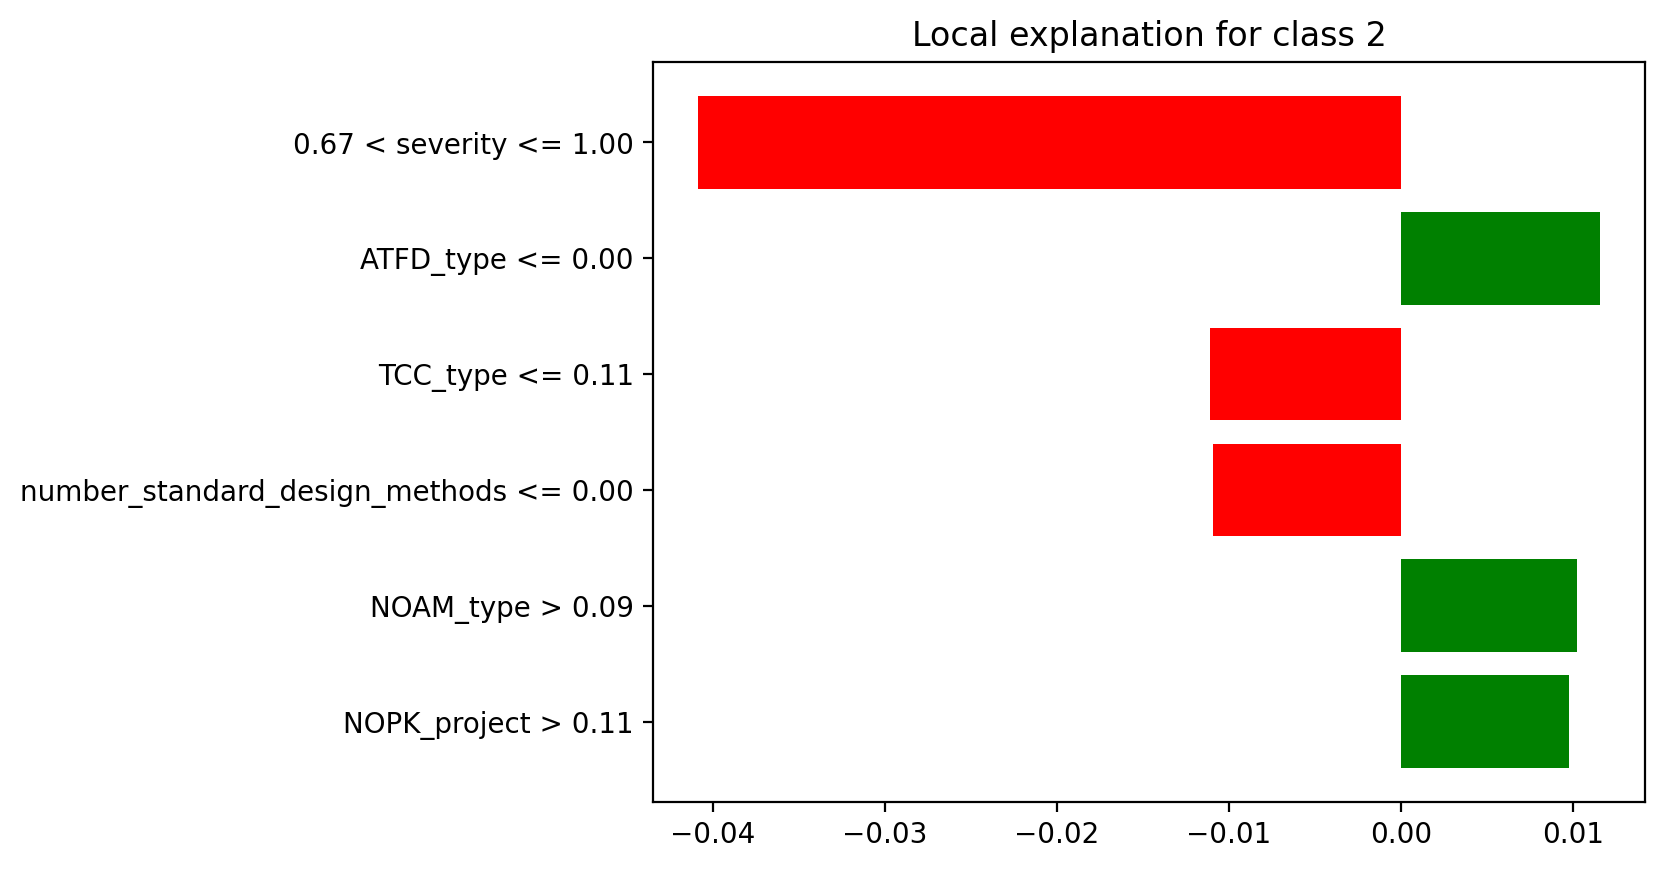

In [ ]:
# Get the explanation for RandomForest
observation_1 = 4
exp = explainer.explain_instance(X_validation[observation_1], predict_fn_rf, num_features=6)
exp.show_in_notebook(show_all=True)
exp.as_pyplot_figure()

In [ ]:
# Model- RandomForest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, Y_train)
accuracy_score(Y_validation, model_rf.predict(X_validation))

0.9285714285714286

In [ ]:
model_logreg = LogisticRegression()
model_logreg.fit(X_train, Y_train)
accuracy_score(Y_validation, model_logreg.predict(X_validation))

0.9285714285714286

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create and fit the Logistic Regression model
model_logreg = LogisticRegression()
model_logreg.fit(X_train, Y_train)

# Make predictions on the validation set
predictions = model_logreg.predict(X_validation)

accuracy = accuracy_score(Y_validation, predictions)
print("Accuracy:", accuracy)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_validation, predictions))

# Print classification report
print("Classification Report:")
print(classification_report(Y_validation, predictions))

Accuracy: 0.9285714285714286
Confusion Matrix:
[[15  0  0  0]
 [ 1  0  2  0]
 [ 0  0  6  0]
 [ 0  0  0 18]]
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      1.00      0.97        15
         2.0       0.00      0.00      0.00         3
         3.0       0.75      1.00      0.86         6
         4.0       1.00      1.00      1.00        18

    accuracy                           0.93        42
   macro avg       0.67      0.75      0.71        42
weighted avg       0.87      0.93      0.90        42



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model_logreg = LogisticRegression()
model_logreg.fit(X, Y)

LogisticRegression()

In [ ]:
predict_fn_logreg = lambda x: model_logreg.predict_proba(x).astype(float)

In [ ]:
# Get the explanation for Logistic Regression
exp = explainer.explain_instance(X_validation[observation_1], predict_fn_logreg, num_features=10)
exp.show_in_notebook(show_all=False)

In [ ]:
# Look at the actual value in the validation set
print(Y_validation[observation_1])

4.0


In [ ]:
# Pick the observation in the validation set for which explanation is required
observation_2 = 45

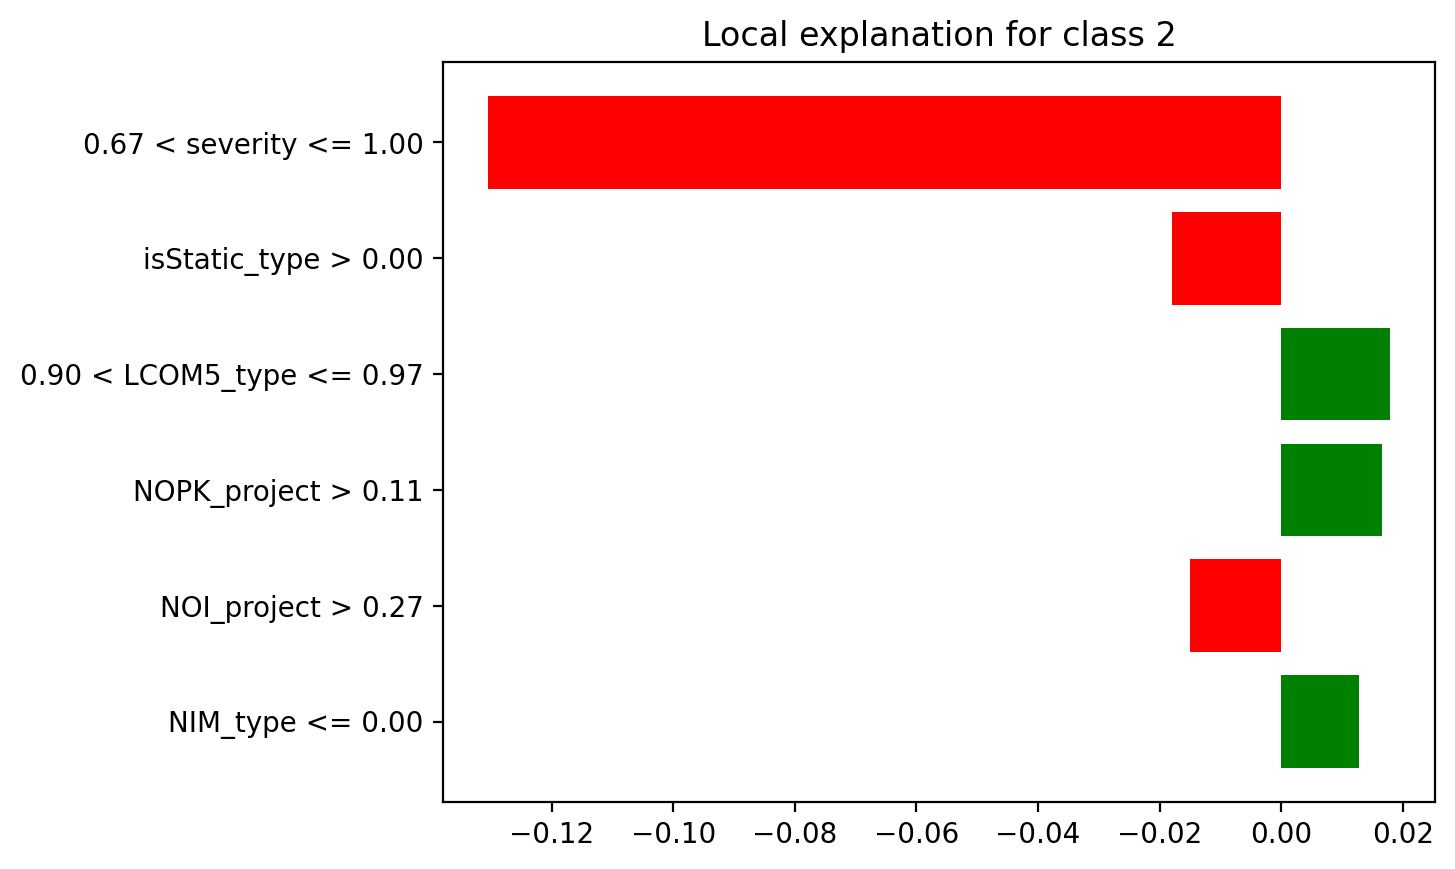

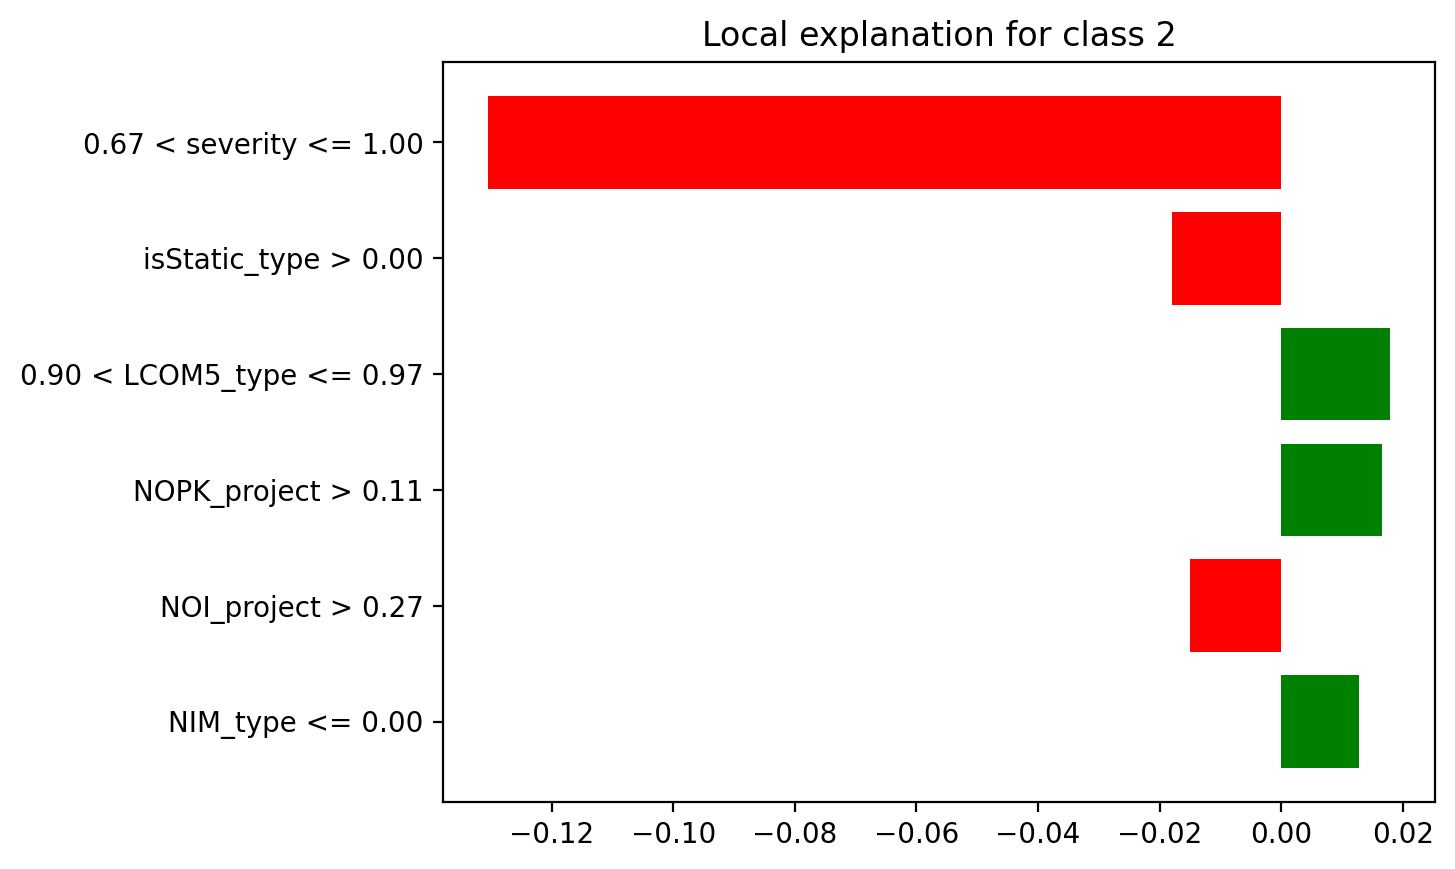

In [ ]:
observation_1 = 4
exp = explainer.explain_instance(X_validation[observation_1], predict_fn_logreg, num_features=6)
exp.show_in_notebook(show_all=True)
exp.as_pyplot_figure()

In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train, Y_train, X_validation, and Y_validation are defined

# Convert Y to integers if needed
Y_train = Y_train.astype(int)
Y_validation = Y_validation.astype(int)

# Optionally adjust class labels if they start from 1
Y_train = Y_train - 1  # Adjust based on your classes
Y_validation = Y_validation - 1

# Fit the model
model_xgb = XGBClassifier()
model_xgb.fit(X_train, Y_train)

# Evaluate accuracy
accuracy = accuracy_score(Y_validation, model_xgb.predict(X_validation))
print("Accuracy:", accuracy)

Accuracy: 1.0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model_xgb.predict(X_validation)
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))


[[15  0  0  0]
 [ 0  3  0  0]
 [ 0  0  6  0]
 [ 0  0  0 18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        18

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

